# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from plotnine import ggplot, aes, geom_line, labs, theme_minimal

df = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv")
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [3]:
df.dropna(inplace=True)

X = df.drop(columns=['species'])
y = df['species']

#dummying
categorical_features = X.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', X.select_dtypes(exclude=['object']).columns),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [4]:
# train test split, stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# kNN
knn_results = []
for k in [3, 10]:
    knn_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier(n_neighbors=k))
    ])
    
    # fit / predict using kNN
    knn_pipeline.fit(X_train, y_train)
    y_pred_knn = knn_pipeline.predict(X_test)
    knn_conf_matrix = confusion_matrix(y_test, y_pred_knn)
    knn_accuracy = accuracy_score(y_test, y_pred_knn)
    knn_class_report = classification_report(y_test, y_pred_knn)
    knn_results.append((k, knn_conf_matrix, knn_accuracy, knn_class_report))



In [5]:
# dt for different complexities
dt_results = []
for depth in [3, None]:
    dt_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(max_depth=depth, random_state=42))
    ])
    
    # fit/predict dt
    dt_pipeline.fit(X_train, y_train)
    y_pred_dt = dt_pipeline.predict(X_test)
    dt_conf_matrix = confusion_matrix(y_test, y_pred_dt)
    dt_accuracy = accuracy_score(y_test, y_pred_dt)
    dt_class_report = classification_report(y_test, y_pred_dt)
    dt_results.append((depth, dt_conf_matrix, dt_accuracy, dt_class_report))

In [6]:
# results
for k, conf_matrix, accuracy, class_report in knn_results:
    print(f"kNN (k={k}) Confusion Matrix:\n{conf_matrix}")
    print(f"kNN (k={k}) Accuracy: {accuracy}")
    print(f"kNN (k={k}) Classification Report:\n{class_report}")



kNN (k=3) Confusion Matrix:
[[28  1  0]
 [ 0 14  0]
 [ 0  0 24]]
kNN (k=3) Accuracy: 0.9850746268656716
kNN (k=3) Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        29
   Chinstrap       0.93      1.00      0.97        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           0.99        67
   macro avg       0.98      0.99      0.98        67
weighted avg       0.99      0.99      0.99        67

kNN (k=10) Confusion Matrix:
[[29  0  0]
 [ 0 14  0]
 [ 0  0 24]]
kNN (k=10) Accuracy: 1.0
kNN (k=10) Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.

In [7]:
for depth, conf_matrix, accuracy, class_report in dt_results:
    depth_str = 'None' if depth is None else str(depth)
    print(f"Decision Tree (max_depth={depth_str}) Confusion Matrix:\n{conf_matrix}")
    print(f"Decision Tree (max_depth={depth_str}) Accuracy: {accuracy}")
    print(f"Decision Tree (max_depth={depth_str}) Classification Report:\n{class_report}")

Decision Tree (max_depth=3) Confusion Matrix:
[[29  0  0]
 [ 1 13  0]
 [ 2  0 22]]
Decision Tree (max_depth=3) Accuracy: 0.9552238805970149
Decision Tree (max_depth=3) Classification Report:
              precision    recall  f1-score   support

      Adelie       0.91      1.00      0.95        29
   Chinstrap       1.00      0.93      0.96        14
      Gentoo       1.00      0.92      0.96        24

    accuracy                           0.96        67
   macro avg       0.97      0.95      0.96        67
weighted avg       0.96      0.96      0.96        67

Decision Tree (max_depth=None) Confusion Matrix:
[[26  3  0]
 [ 0 14  0]
 [ 2  0 22]]
Decision Tree (max_depth=None) Accuracy: 0.9253731343283582
Decision Tree (max_depth=None) Classification Report:
              precision    recall  f1-score   support

      Adelie       0.93      0.90      0.91        29
   Chinstrap       0.82      1.00      0.90        14
      Gentoo       1.00      0.92      0.96        24

    accura

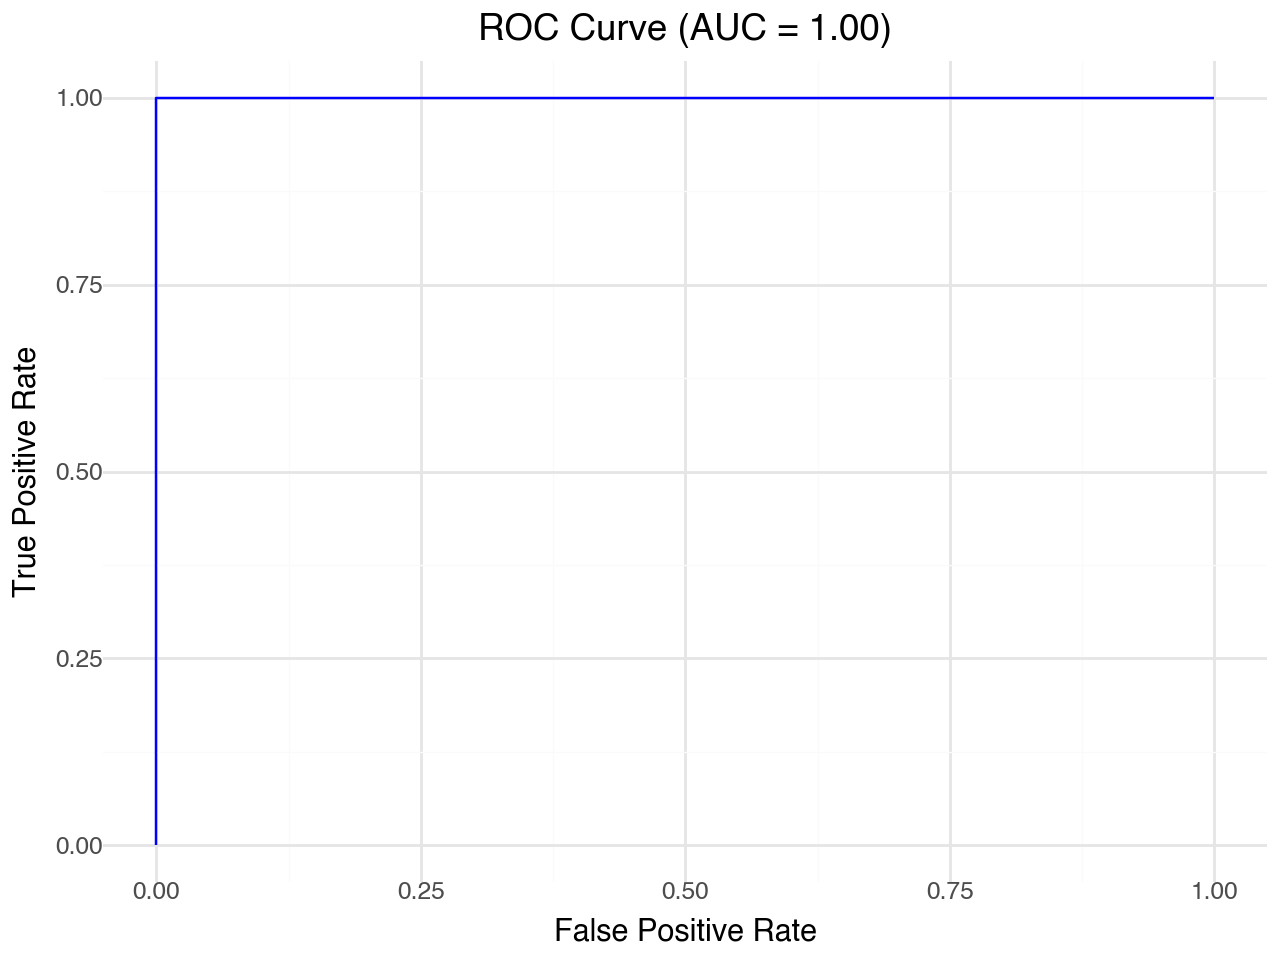

In [8]:
# ROC for one species
y_bin = label_binarize(y, classes=['Adelie', 'Chinstrap', 'Gentoo'])
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_bin, test_size=0.2, random_state=42, stratify=y_bin)

# OneVsRestClassifier for ROC
knn_pipeline_bin = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3)))
])

knn_pipeline_bin.fit(X_train_bin, y_train_bin)
y_score_knn = knn_pipeline_bin.predict_proba(X_test_bin)

# calc ROC and AUC for one class
fpr, tpr, _ = roc_curve(y_test_bin[:, 0], y_score_knn[:, 0])
roc_auc = auc(fpr, tpr)

# Plot
roc_df = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr})
(ggplot(roc_df, aes(x='False Positive Rate', y='True Positive Rate')) +
        geom_line(color='blue') +
        labs(title=f'ROC Curve (AUC = {roc_auc:.2f})', x='False Positive Rate', y='True Positive Rate') +
        theme_minimal())
